In [38]:
import os
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
import numpy as np
# import aML.HW2.other.model_structure as model_structure
path = "/Users/liushiwen/Desktop/大四下/hw2/test_data"
path = "D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train"
dir_list = os.listdir(path)

print(f"Files and directories in '{path}':")

Files and directories in 'D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train':


0	0.7734375	0.4296875	0.21875	0.21875

(128, 128, 4)


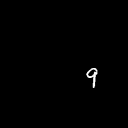

In [39]:
f = open(f"{path}/0000002.txt", "r")
print(f.read())
img = Image.open(f'{path}/0121744.png')
img = np.array(img)
print(img.shape)
img = Image.fromarray(img[:,:,2])
display(img)

In [40]:
img = Image.open(f'{path}/0121700.png')
r, g, b, trash = img.split()

r_array = np.array(r)
g_array = np.array(g)
b_array = np.array(b)

# Check if all channels have the same array values
are_channels_same = np.array_equal(r_array, g_array) and np.array_equal(g_array, b_array)
are_channels_same

True

In [41]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_files[idx])
        image = read_image(image_path)
        image = image[0:3].float()
        # image = image.reshape(1, 128, 128)
        
        txt_file = os.path.splitext(self.image_files[idx])[0] + ".txt"
        txt_path = os.path.join(self.data_folder, txt_file)
        with open(txt_path, "r") as f:
            first_line = f.readline().strip()
            class_label = int(first_line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, class_label
    
transform = transforms.Compose([])
data_folder = path
custom_dataset = CustomImageDataset(data_folder, transform)


In [42]:
import random
from torch.utils.data import DataLoader, Subset
def get_dataloaders(data_folder, transform, train_ratio, val_ratio, batch_size):
    # Create a single merged dataset
    train_dataset = CustomImageDataset(data_folder, transform)
    val_dataset = CustomImageDataset(data_folder, transform)
    test_dataset = CustomImageDataset(data_folder, transform)

    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"Data Transform: {transform}")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders

In [93]:
loaders = get_dataloaders(data_folder, transform, 0.01, 0.5, 256)

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [67332, 47905, 40562, 81512, 86722]
--------- INDEX shuffled ---------

Total number of samples: 97396 datapoints
Number of train samples: 4 batches/ 973 datapoints
Number of val samples: 189 batches/ 48211 datapoints
Number of test samples: 189 batches/ 48212 datapoints
Data Transform: Compose(
)



In [44]:
def count_parameters(model):
    total_num = 0

    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num


In [47]:
from datetime import datetime

def pprint(output = '\n', show_time = False): # print and fprint at the same time
    filename = "hw2-1-3-MAR23.txt"
    print(output)
    with open(filename, 'a') as f:
        if show_time:
            f.write(datetime.now().strftime("[%Y-%m-%d %H:%M:%S] "))

        f.write(str(output))
        f.write('\n')
pprint("OFFICIAL START, Focus on the 3rd problem", True)

Focus on the 3rd problem


In [94]:
import time
from torch import nn, optim
from tqdm import tqdm

def train(model, model_name):
    # pprint(f"test modify Resnet18 {model_name}", True)
    model_parameters_amount = count_parameters(model)
    pprint(f"model total parameters: {model_parameters_amount:,}")

    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    lr= 0.005
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.2)
    pprint(f"learning rate={lr}")
    iteration = 0
    epochs = 1
    start = time.time()
    phases = ['train']
    # return 
    for epoch in range(epochs):
        for phase in phases:
            running_loss = 0.0
            correct_predictions = 0
            correct_top3_predictions = 0
            total_samples = 0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            for images, labels in tqdm(loaders[phase]): # Iterate over data.
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train': # backward + optimize only if in training phase
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                
                _, top3_preds = outputs.topk(3, 1, True, True)
                correct_top3_predictions += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])

                total_samples += labels.size(0)
                iteration += 1

            avg_loss = running_loss / total_samples
            top1_accuracy = correct_predictions / total_samples * 100
            top3_accuracy = correct_top3_predictions / total_samples * 100
            pprint(f"Epoch [{epoch+1}/{epochs}], phase: {phase}, samples: {total_samples}, Loss: {avg_loss:.4f}, Top-1 Accuracy: {top1_accuracy:.2f}%, Top-3 Accuracy: {top3_accuracy:.2f}%")
    end = time.time()
    duration = end - start
    pprint(f"Elapsed time: {duration} seconds")
    return
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_scripted.save(f'{model_name}.pt') # Save
    pprint(f"weight saved as: {model_name}.pt")

In [98]:
import torchvision.models as models

model_lists = {
    'resnet18': lambda: models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
    'resnet50': lambda: models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'resnet101': lambda: models.resnet101(weights=models.ResNet101_Weights.DEFAULT),
    'resnet152': lambda: models.resnet152(weights=models.ResNet152_Weights.DEFAULT),
    'swin_v2_t': lambda: models.swin_t(weights=models.Swin_T_Weights.DEFAULT),
    'swin_v2_s': lambda: models.swin_s(weights=models.Swin_S_Weights.DEFAULT),
    'swin_v2_b': lambda: models.swin_b(weights=models.Swin_B_Weights.DEFAULT),
}

model_names = [
    'resnet18',
    'resnet50',
    'resnet101',
    'resnet152',
    'swin_v2_t',
    'swin_v2_s',
    'swin_v2_b',
]
for model_name in model_names:
    model = model_lists[model_name]()
    train(model, model_name)

model total parameters: 11,689,512
learning rate=0.005


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


Epoch [1/1], phase: train, samples: 973, Loss: 0.0384, Top-1 Accuracy: 1.34%, Top-3 Accuracy: 3.60%
Elapsed time: 1.1196253299713135 seconds


 47%|████▋     | 46.4M/97.8M [00:05<00:05, 10.7MB/s]

100%|██████████| 97.8M/97.8M [00:09<00:00, 10.3MB/s]


model total parameters: 25,557,032
learning rate=0.005


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Epoch [1/1], phase: train, samples: 973, Loss: 0.0295, Top-1 Accuracy: 0.00%, Top-3 Accuracy: 0.00%
Elapsed time: 3.528817892074585 seconds


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:16<00:00, 10.9MB/s] 


model total parameters: 44,549,160
learning rate=0.005


100%|██████████| 4/4 [00:14<00:00,  3.51s/it]


Epoch [1/1], phase: train, samples: 973, Loss: 0.0296, Top-1 Accuracy: 0.82%, Top-3 Accuracy: 1.44%
Elapsed time: 14.052119255065918 seconds


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:26<00:00, 9.23MB/s] 


model total parameters: 60,192,808
learning rate=0.005


100%|██████████| 4/4 [00:18<00:00,  4.69s/it]


Epoch [1/1], phase: train, samples: 973, Loss: 0.0299, Top-1 Accuracy: 0.00%, Top-3 Accuracy: 0.10%
Elapsed time: 18.755255222320557 seconds
model total parameters: 28,288,354
learning rate=0.005


100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


Epoch [1/1], phase: train, samples: 973, Loss: 0.0286, Top-1 Accuracy: 2.57%, Top-3 Accuracy: 7.50%
Elapsed time: 12.918222904205322 seconds
model total parameters: 49,606,258
learning rate=0.005


100%|██████████| 4/4 [00:27<00:00,  6.92s/it]


Epoch [1/1], phase: train, samples: 973, Loss: 0.0265, Top-1 Accuracy: 4.73%, Top-3 Accuracy: 10.07%
Elapsed time: 27.675967931747437 seconds
model total parameters: 87,768,224
learning rate=0.005


100%|██████████| 4/4 [00:47<00:00, 11.97s/it]

Epoch [1/1], phase: train, samples: 973, Loss: 0.0269, Top-1 Accuracy: 4.01%, Top-3 Accuracy: 8.63%
Elapsed time: 47.90890598297119 seconds


In [75]:
def majority_voting(output_list):
    stacked_outputs = torch.stack(output_list)
    avg_probs = torch.mean(stacked_outputs, dim=0)
    
    return avg_probs

In [88]:
import time
from torch import nn, optim
from tqdm import tqdm

def eval(model_list):
    for model in model_list:
        model.cuda()
        model.eval()
    criterion = nn.CrossEntropyLoss()
    start = time.time()
    phases = ['val']
    num_class = 10
    for phase in phases:
        running_loss = 0.0
        correct_predictions = 0
        correct_top3_predictions = 0
        total_samples = 0
        confus = torch.zeros(num_class, num_class,dtype=int)            
        for images, labels in tqdm(loaders[phase]): # Iterate over data.
            images, labels = images.cuda(), labels.cuda()
            model_outputs = []
            for model in model_list:
                with torch.no_grad():
                    outputs = model(images)
                    model_outputs.append(outputs)
            vote_outputs = majority_voting(model_outputs)
            loss = criterion(vote_outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(vote_outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            
            _, top3_preds = outputs.topk(3, 1, True, True)
            correct_top3_predictions += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])
            total_samples += labels.size(0)

            for ii in range(len(predicted)):
                confus[ labels.data[ii] ][ predicted[ii] ]+=1

        avg_loss = running_loss / total_samples
        top1_accuracy = correct_predictions / total_samples * 100
        top3_accuracy = correct_top3_predictions / total_samples * 100
        pprint(f"Phase: {phase}, samples: {total_samples}, Loss: {avg_loss:.4f}, Top-1 Accuracy: {top1_accuracy:.2f}%, Top-3 Accuracy: {top3_accuracy:.2f}%")
        for ii in range(num_class) :
            pprint(f"class {ii}:{confus.numpy()[ii]}")
        # pprint(confus)

    end = time.time()
    duration = end - start
    pprint(f"Elapsed time: {duration} seconds")

In [91]:
import torchvision.models as models
path = "D:\\Casper\\aML\\HW2\\aML\\"
model_list = [
    # torch.jit.load(f'{path}R6_btnk_4ch8n4.pt'),
    torch.jit.load(f'{path}R6_btnk_ch8(hw2).pt'),
    # torch.jit.load(f'{path}resnet6.pt'),
    # models.resnet18(weights=True),
    # models.resnet50(weights=True),
    # models.resnet101(weights=True),
    # models.resnet152(weights=True),
    # models.swin_v2_t(weights=True),
    # models.swin_v2_s(weights=True),
    # models.swin_v2_b(weights=True),
    # models.vit_h_14(weights=models.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1),
]

model_name = [
    'resnet18',
    # 'resnet50',
    # 'resnet101',
    # 'resnet152',
    # 'swin_v2_t',
    # 'swin_v2_s',
    # 'swin_v2_b',
    # 'vit_h_14',
]
eval(model_list)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

Phase: val, samples: 487, Loss: 0.0006, Top-1 Accuracy: 95.89%, Top-3 Accuracy: 99.59%
class 0:[42  0  0  0  0  0  0  0  0  0]
class 1:[ 1 56  0  0  0  0  0  0  0  0]
class 2:[ 0  0 40  0  0  0  0  0  2  1]
class 3:[ 1  0  0 36  0  0  0  1  0  0]
class 4:[ 0  0  0  0 51  0  0  0  0  1]
class 5:[ 0  1  0  0  0 51  0  0  2  0]
class 6:[ 0  0  0  0  0  0 48  0  0  0]
class 7:[ 1  0  0  0  0  0  0 56  0  2]
class 8:[ 6  0  0  0  0  0  0  0 47  1]
class 9:[ 0  0  0  0  0  0  0  0  0 40]
Elapsed time: 0.4988720417022705 seconds
